# Unsupervised Learning

In [33]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## K-Means

In [9]:
from sklearn.cluster import KMeans

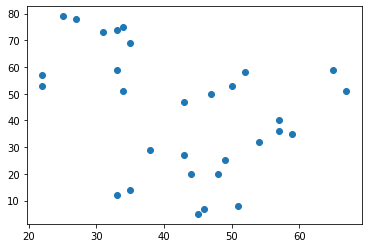

In [10]:
# data from https://datatofish.com/k-means-clustering-python/
X = np.array([
    [25,34,22,27,33,33,31,22,35,34,67,54,57,43,50,57,59,52,65,47,49,48,35,33,44,45,38,43,51,46],
    [79,51,53,78,59,74,73,57,69,75,51,32,40,47,53,36,35,58,59,50,25,20,14,12,20,5,29,27,8,7]
])
plt.scatter(X[0], X[1])

In [26]:
kmeans = KMeans(n_clusters=4, init='random')
kmeans.fit(X.transpose())

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=4,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [27]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[3 2 3 3 3 3 3 3 3 3 1 1 1 2 2 1 1 2 1 2 0 0 0 0 0 0 0 0 0 0]
[[43.2        16.7       ]
 [59.83333333 42.16666667]
 [45.2        51.8       ]
 [29.11111111 68.55555556]]


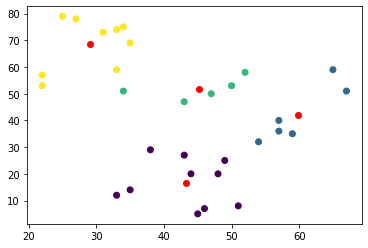

In [28]:
plt.figure()
plt.scatter(X[0], X[1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red')

In [23]:
# test with new points
kmeans.predict(np.array([[30,70]]))

array([0], dtype=int32)

### Evaluating KMeans

In [29]:
kmeans.inertia_

2940.077777777778

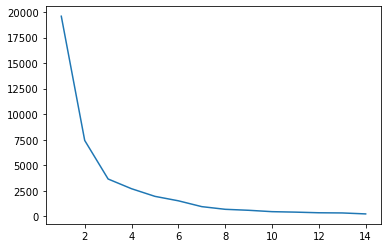

In [32]:
# the elbow!
elbow = []
n_clusters = range(1,15)
for K in n_clusters:
    kmeans = KMeans(n_clusters=K, init='random')
    kmeans.fit(X.transpose())
    elbow.append(kmeans.inertia_)
plt.plot(n_clusters, elbow)

## Autoencoders

In [135]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

train_dataset = MNIST('.data', download=False, train=True, transform=ToTensor())
test_dataset = MNIST('.data', download=False, train=False, transform=ToTensor()) # we will never use it! Why?

# filter out some labels
idx = (train_dataset.targets==0) | (train_dataset.targets==1)  | (train_dataset.targets==2)
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

tr_length = int(len(train_dataset) * 0.7)
print(tr_length)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                [tr_length, len(train_dataset)-tr_length])
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

13036


In [136]:
class MLP(nn.Module):
    def __init__(self, hidden_size):

        super(MLP, self).__init__()
        
        input_size = 28*28
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        self.out1 = torch.relu(self.l1(x))
        out = self.l2(self.out1)
        return out

In [137]:
autoencoder = MLP(2)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
                             #weight_decay=1e-2)
criterion = torch.nn.MSELoss()

In [138]:
EPOCHS = 20

tr_loss = []
val_loss = []
for epoch in range(EPOCHS):
    trl = 0.
    for x,_ in train_loader:
        x = x.view(x.size(0), -1)
        optimizer.zero_grad()    
        out = autoencoder(x)
        loss = criterion(out, x)
        loss.backward()
        optimizer.step()
        trl += loss.item()
        
    tr_loss.append(trl / float(len(train_loader)))    
    
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.view(x.size(0), -1)
            out = autoencoder(x)
            vll = criterion(out, x)
            val_loss.append(vll.item())
            
    print(f'End epoch {epoch}')

End epoch 0
End epoch 1
End epoch 2
End epoch 3
End epoch 4
End epoch 5
End epoch 6
End epoch 7
End epoch 8
End epoch 9
End epoch 10
End epoch 11
End epoch 12
End epoch 13
End epoch 14
End epoch 15
End epoch 16
End epoch 17
End epoch 18
End epoch 19


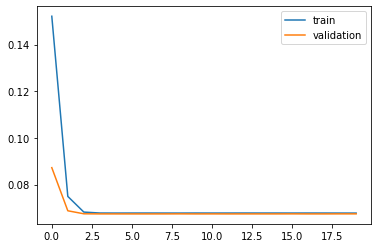

In [139]:
plt.plot(range(len(tr_loss)), tr_loss, label='train')
plt.plot(range(len(val_loss)), val_loss, label='validation')
plt.legend(loc='best')

In [140]:
activations = []
targets = []
with torch.no_grad():
    for i, (x, y) in enumerate(val_loader):
        x = x.view(x.size(0), -1)        
        autoencoder(x)
        activations.append(autoencoder.out1.numpy())
        targets.append(y.numpy())

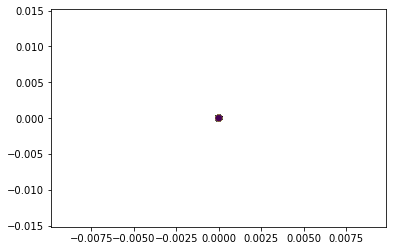

In [141]:
plt.scatter(activations[0][:,0], activations[0][:, 1], c=targets[0])